In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import powerlaw
from scipy.stats import combine_pvalues, norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import glob
import ast

# Plots and testing for Hypothesis 1

### Drupsteen model

In [2]:
path = R'C:\Users\nitai\OneDrive\MScCLS\Complex system simulation\FinancialNetwork\Data our model'


In [3]:
def get_files_with_parameters(directory_path, input_parameters):
    # Read all files in the directory
    
    all_files = os.listdir(directory_path)
    print('all files in directory: ', all_files)

    # List to hold DataFrames of files that match the input parameters
    matching_files_data = []

    for filename in all_files:
        # Split the filename on the first underscore to drop the initial number sequence
        parts = filename.split('_', 1)
        if len(parts) == 2:
            # Split the parameters part on the last underscore to drop the timestamp
            prefix, parameters_with_timestamp = parts
            parameters = '_'.join(parameters_with_timestamp.split('_')[:-1])
            
            # Check if the file parameters match the input parameters
            if input_parameters in parameters:
                # Construct the full path to the file
                file_path = os.path.join(directory_path, filename)
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path)
                # Add the DataFrame to the list
                matching_files_data.append(df)

    return matching_files_data

In [4]:
input_parameters = '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate'

# Get the matching files
selected_files = get_files_with_parameters(path, input_parameters)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\nitai\\OneDrive\\MScCLS\\Complex system simulation\\FinancialNetwork\\Data our model'

In [5]:
def select_variable_given_list_of_dfs(selected_dfs: list, variable_name: str):
    # List to hold Series or lists of the selected variable from each DataFrame
    list_of_series_or_lists = []

    for df in selected_dfs:
        # Check if the variable_name column exists to avoid KeyError
        if variable_name in df.columns:

            print('parameters', df.iloc[0,:1])
            # Drop first row from the DataFrame
            df = df.drop(df.index[0])

            # Extract the variable column as it contains NANs
            variable_series = df[variable_name]
            
            # Since the column is an object type (possibly containing lists or arrays), 
            # no conversion to numeric is done here. Instead, we directly append the column.
            list_of_series_or_lists.append(variable_series)
        else:
            print(f"The variable '{variable_name}' is not in the DataFrame.")

    print('list_of_series_or_lists:', list_of_series_or_lists)
    return list_of_series_or_lists

In [6]:
data_our_model = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')

NameError: name 'selected_files' is not defined

In [7]:
def convert_string_to_list(string):
    # Remove the square brackets
    string = string.strip('[]')
    # Split the string on commas
    string = string.split(',')
    # Convert each string in the list to a float
    string = [float(s) for s in string]
    return string

In [8]:
titles = ['100 Agents', '200 Agents', '300 Agents']

In [9]:
def plot_bankruptcy_analysis_multiple_arrays(data_array, titles, param_caption):
    """
    Plots the bankruptcy analysis with three subplots for each file in data_array.
    :param data_array: List of pandas DataFrames with bankruptcy data.
    """
    for file_index, file in enumerate(data_array):
        plt.figure(figsize=(10, 12))
        for run in range(file.shape[0]):
            diff_bankrupt_agents = file.iloc[run]
            diff_bankrupt_agents = convert_string_to_list(diff_bankrupt_agents)
            time_steps = np.arange(len(diff_bankrupt_agents))

            # Subplot 1: Difference in Number of Bankrupt Agents
            plt.subplot(3, 1, 1)
            plt.plot(time_steps, diff_bankrupt_agents, label=f'Run {run+1}', color='orange')
            plt.xlabel('Time Step')
            plt.ylabel('Difference in Number of Bankrupt Agents')
            plt.title(f'N = {titles[file_index]} - Difference in Number of Bankrupt Agents Over Time')
            plt.legend()

            # Subplot 2: Cumulative Histogram of Absolute Difference in Bankrupt Agents
            plt.subplot(3, 1, 2)
            plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label=f'Run {run+1}', histtype='step', density=True)
            plt.xscale('log')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents (Log Scale)')
            plt.ylabel('1 - Cumulative Count (Log Scale)')
            plt.title(f'N = {titles[file_index]} - Cumulative Histogram of |Difference in Bankrupt Agents| Over Time')
            plt.legend()

            # Subplot 3: Frequency of Absolute Differences in Number of Bankrupt Agents
            plt.subplot(3, 1, 3)
            unique_diffs, counts = np.unique(np.abs(diff_bankrupt_agents), return_counts=True)
            plt.scatter(unique_diffs, counts, label=f'Run {run+1}')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
            plt.ylabel('Frequency of Occurrence')
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f'N = {titles[file_index]} - Frequency of Absolute Differences in Number of Bankrupt Agents')
            plt.legend()
            param_caption_str = ', '.join([f"{key}={value}" for key, value in param_caption.items()])
            plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
            plt.tight_layout()  # Adjust the rect to make space for the figtext
        plt.show()


In [10]:
param_caption = { "runs": 5,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "threshold_v": 5,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": 'divide exposure singly',
  "bankruptcy_mode": "intrest_rate",
}

In [11]:
plot_bankruptcy_analysis_multiple_arrays(data_our_model, titles, param_caption)

NameError: name 'data_our_model' is not defined

In [12]:
def probability_of_default(data_array, threshold):
    return [1 if x > threshold else 0 for x in data_array]/len(data_array)

In [13]:
def fit_power_law_array(data_array, titles):
    """
    Fit data from multiple arrays to a power-law distribution and compare it with an exponential distribution.
    Includes an aggregated p-value using Stouffer's Z-method in its own row below the runs it aggregates.

    Parameters:
    data_array (List[pd.DataFrame]): List of pandas DataFrames with data to be fitted.
    titles (List[str]): List of titles corresponding to each DataFrame in data_array.

    Returns:
    pd.DataFrame: A DataFrame containing individual run data and aggregated p-values for each title.
    """
    results_list = []

    for file_index, file in enumerate(data_array):
        p_values = []
        for run in range(file.shape[0]):
            run_data = file.iloc[run]
            run_data = convert_string_to_list(run_data)

            # Fit the data to a power-law distribution
            results = powerlaw.Fit(run_data)
            alpha = results.power_law.alpha
            R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
            p_values.append(p)


            # Format p-value with significance levels
            p_value_formatted = f"{np.round(p, 4)}"
            if p < 0.001:
                p_value_formatted += "***"  # Highly significant
            elif p < 0.01:
                p_value_formatted += "**"   # Very significant
            elif p < 0.05:
                p_value_formatted += "*"    # Significant

            # Add results to list
            results_list.append({
                'N agents (Nodes)': titles[file_index],
                'run': run + 1,
                'alpha exponent': alpha,
                'likelihood ratio': R,
                'p-value': p_value_formatted
            })

            # Aggregate p-values for this title using Stouffer's Z-method from statsmodels
            combined_test_stat, aggregated_p_value = combine_pvalues(p_values, method='stouffer')


            # Format aggregated_p_value p-value with significance levels
            aggregated_p_value_formatted = f"{np.round(aggregated_p_value, 4)}"
            if aggregated_p_value < 0.001:
                aggregated_p_value_formatted += "***"  # Highly significant
            elif aggregated_p_value < 0.01:
                aggregated_p_value_formatted += "**"   # Very significant
            elif aggregated_p_value < 0.05:
                aggregated_p_value_formatted += "*"    # Significant



        results_list.append({
            'N agents (Nodes)': '',
            'run': 'Stouffer’s p-value',
            'alpha exponent': '',
            'likelihood ratio': '',
            'p-value': aggregated_p_value_formatted
        })

    # Create DataFrame for all results
    results_df = pd.DataFrame(results_list)
    return results_df

In [14]:
fit_power_law_array(data_our_model, titles)

NameError: name 'data_our_model' is not defined

# Drupsteen model

In [15]:
path = R'C:\Users\nitai\OneDrive\MScCLS\Complex system simulation\FinancialNetwork\Data papers model'


In [16]:
# 200_2000_1_2_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131155859

<!-- '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate' -->

In [17]:
input_parameters = '2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure'

# Get the matching files
selected_files = get_files_with_parameters(path, input_parameters)

data_paper = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\nitai\\OneDrive\\MScCLS\\Complex system simulation\\FinancialNetwork\\Data papers model'

In [18]:
param_caption = { "runs": 5,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "threshold_v": 5,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": '_random link logic',
  "bankruptcy_mode": "link logic_exposure",
}

In [19]:
plot_bankruptcy_analysis_multiple_arrays(data_paper, titles, param_caption)

NameError: name 'data_paper' is not defined

In [20]:
data_paper

NameError: name 'data_paper' is not defined

In [21]:
fit_power_law_array(data_paper, titles)

NameError: name 'data_paper' is not defined

# Plot 2: Our model

In [37]:
path_model = R'E:\CLS\FinancialNetwork\model'
path_paper = R'E:\CLS\FinancialNetwork\paper'

input_parameters_model = '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate'
input_parameters_paper = '2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure'

selected_files_model = get_files_with_parameters(path_model, input_parameters_model)
selected_files_paper = get_files_with_parameters(path_paper, input_parameters_paper)

data_plot_2_our_model_diff_agents = select_variable_given_list_of_dfs(selected_files_model, 'Abs Difference of Bankrupt Agents Over Time')
data_plot_2_paper_diff_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Abs Difference of Bankrupt Agents Over Time')
data_plot_2_our_model_num_agents = select_variable_given_list_of_dfs(selected_files_model, 'Number of Bankrupt Agents Over Time')
data_plot_2_paper_num_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Number of Bankrupt Agents Over Time')

all files in directory:  ['100_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240201000132.csv', '200_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240201001322.csv', '300_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240201045936.csv', '400_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240201012456.csv', '500_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240201023520.csv']
all files in directory:  ['100_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201023652.csv', '200_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201024300.csv', '300_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201025542.csv', '400_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201031526.csv', '500_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201034215.csv']
parameters Combination    (100, 2000, 1, 1,

In [38]:
def perform_regression(dependent_var, *independent_vars):
    """
    Perform linear regression (simple or multiple) based on the number of independent variables provided.

    Parameters:
    dependent_var (array-like): The dependent variable.
    independent_vars (variable number of array-like): The independent variable(s).

    Returns:
    RegressionResults: The results of the regression analysis.
    """
    # Combine independent variables into a DataFrame
    data = pd.DataFrame({f'var{i}': var for i, var in enumerate(independent_vars, start=1)})

    # Add the dependent variable
    data['dependent'] = dependent_var

    # Define the formula
    independent = ' + '.join(data.columns[:-1])
    formula = f'dependent ~ {independent}'

    # Fit the model
    model = sm.OLS.from_formula(formula, data).fit()

    return model.summary()

In [39]:
def compare_group_means(*groups):
    """
    Compare means of multiple groups using ANOVA or Kruskal-Wallis test.
    Includes a conclusion based on the hypothesis test.
    """
    # Check for zero variance within each group
    if any(np.ptp(group) == 0 for group in groups):
        print("One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.")
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

    # Create a DataFrame to hold all groups data
    group_labels = [f'group{i+1}' for i in range(len(groups))]
    data_values = []
    data_groups = []
    for i, group in enumerate(groups):
        data_values.extend(group)
        data_groups.extend([group_labels[i]] * len(group))
    
    df = pd.DataFrame({'value': data_values, 'group': data_groups})

    # Checking for normality and homogeneity of variances
    normality_p_values = [stats.shapiro(df[df['group'] == group]['value']).pvalue for group in group_labels]
    normal = all(p > 0.05 for p in normality_p_values)
    homogeneity_p_value = stats.levene(*groups).pvalue
    homogeneous = homogeneity_p_value > 0.05

    if normal and homogeneous:
        print("The data is normal and homogeneous, performing ANOVA.")
        # Perform ANOVA
        model = ols('value ~ C(group)', data=df).fit()
        anova_result = sm.stats.anova_lm(model, typ=2)
        conclusion = "There is no significant difference between the groups." if anova_result['PR(>F)'].iloc[0] > 0.05 else "There is a significant difference between the groups."
        return f"ANOVA Result:\n{anova_result}\nConclusion: {conclusion}"
    else:
        print("The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.")
        # Perform Kruskal-Wallis Test
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

In [40]:
def is_default(bankrupt_agents, threshold, system_size):
    return bankrupt_agents >= threshold * system_size

def calculate_default_probability(bankrupt_agents_list, threshold, system_size):
    defaults = [is_default(ba, threshold, system_size) for ba in bankrupt_agents_list]
    num_defaults = sum(defaults)
    default_probability = num_defaults / len(bankrupt_agents_list) if len(bankrupt_agents_list) > 0 else 0
    return default_probability, num_defaults

def adjust_bankrupt_agents(num_bankrupt_agents_str, diff_bankrupt_agents_str):
    num_bankrupt_agents = convert_string_to_list(num_bankrupt_agents_str)
    diff_bankrupt_agents = convert_string_to_list(diff_bankrupt_agents_str)
    return [num_bankrupt_agents[0]] + diff_bankrupt_agents[:-1]

In [41]:
def plot_default_size(data_array_num_model, data_array_diff_model, data_array_num_paper, data_array_diff_paper, titles, system_sizes, default_consideration_threshold):
    all_data_model = {}
    all_data_paper = {}

    # Process model data
    for system_size, num_data, diff_data in zip(system_sizes, data_array_num_model, data_array_diff_model):
        default_probabilities = []
        for num_str, diff_str in zip(num_data, diff_data):
            adjusted_bankrupt_agents = adjust_bankrupt_agents(num_str, diff_str)
            default_probability, _ = calculate_default_probability(adjusted_bankrupt_agents, default_consideration_threshold, system_size)
            default_probabilities.append(default_probability)
        all_data_model[system_size] = default_probabilities

    # Process Drupsteen data
    for system_size, num_data, diff_data in zip(system_sizes, data_array_num_paper, data_array_diff_paper):
        default_probabilities = []
        for num_str, diff_str in zip(num_data, diff_data):
            adjusted_bankrupt_agents = adjust_bankrupt_agents(num_str, diff_str)
            default_probability, _ = calculate_default_probability(adjusted_bankrupt_agents, default_consideration_threshold, system_size)
            default_probabilities.append(default_probability)
        all_data_paper[system_size] = default_probabilities

    # Plotting box plots
    plt.figure(figsize=(10, 6))
    positions_model = [i*2 for i, _ in enumerate(system_sizes)]
    positions_paper = [i*2 + 1 for i, _ in enumerate(system_sizes)]

    box_data_model = [all_data_model[size] for size in system_sizes]
    box_data_paper = [all_data_paper[size] for size in system_sizes]

    plt.boxplot(box_data_model, positions=positions_model, widths=0.6, patch_artist=True, boxprops=dict(facecolor='blue'))
    plt.boxplot(box_data_paper, positions=positions_paper, widths=0.6, patch_artist=True, boxprops=dict(facecolor='orange'))

    plt.xticks([i*2 + 0.5 for i, _ in enumerate(system_sizes)], [f'N={size}' for size in system_sizes])
    plt.xlabel('System Size')
    plt.ylabel('Default Probability')
    plt.title('Comparison of Default Probability per System Size')
    plt.legend(['Model', 'Drupsteen'])
    plt.grid(True)
    plt.show()

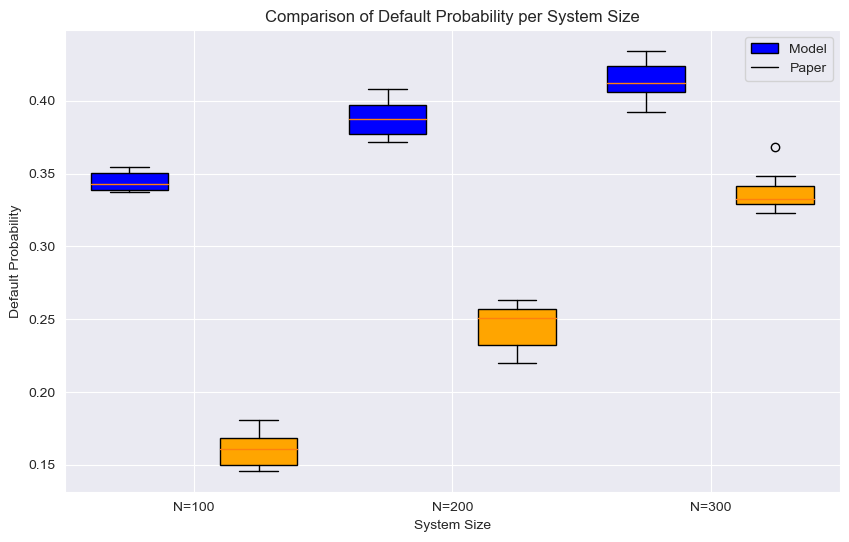

In [46]:
system_sizes = [100, 200, 300]

default_consideration_threshold = 0.001
plot_default_size(data_array_num_model=data_plot_2_our_model_num_agents, data_array_diff_model=data_plot_2_our_model_diff_agents, data_array_num_paper=data_plot_2_paper_num_agents, data_array_diff_paper=data_plot_2_paper_diff_agents, titles=titles, system_sizes=system_sizes, default_consideration_threshold=default_consideration_threshold)

In [47]:
def plot_default_size_dot(data_array_num_model, data_array_diff_model, data_array_num_paper, data_array_diff_paper, titles, system_sizes, default_consideration_threshold):
    plt.figure(figsize=(10, 6))

    all_default_probs_model = {size: [] for size in system_sizes}
    all_default_probs_paper = {size: [] for size in system_sizes}

    # Processing model data
    for size, num_data, diff_data in zip(system_sizes, data_array_num_model, data_array_diff_model):
        for num_str, diff_str in zip(num_data, diff_data):
            adjusted_bankrupt_agents = adjust_bankrupt_agents(num_str, diff_str)
            default_probability, _ = calculate_default_probability(adjusted_bankrupt_agents, default_consideration_threshold, size)
            all_default_probs_model[size].append(default_probability)

    # Processing Drupsteen data
    for size, num_data, diff_data in zip(system_sizes, data_array_num_paper, data_array_diff_paper):
        for num_str, diff_str in zip(num_data, diff_data):
            adjusted_bankrupt_agents = adjust_bankrupt_agents(num_str, diff_str)
            default_probability, _ = calculate_default_probability(adjusted_bankrupt_agents, default_consideration_threshold, size)
            all_default_probs_paper[size].append(default_probability)

    # Plotting model data
    for size in system_sizes:
        plt.scatter([size] * len(all_default_probs_model[size]), all_default_probs_model[size], alpha=0.5, color='blue', label='Model' if size == system_sizes[0] else "")
        mean_prob_model = np.mean(all_default_probs_model[size])
        std_prob_model = np.std(all_default_probs_model[size])
        plt.errorbar(size, mean_prob_model, yerr=std_prob_model, fmt='o', color='red', capsize=5, label='Mean with Std Dev - Model' if size == system_sizes[0] else "")

    # Plotting Drupsteen data
    for size in system_sizes:
        plt.scatter([size + 0.2] * len(all_default_probs_paper[size]), all_default_probs_paper[size], alpha=0.5, color='green', label='Drupsteen' if size == system_sizes[0] else "")
        mean_prob_paper = np.mean(all_default_probs_paper[size])
        std_prob_paper = np.std(all_default_probs_paper[size])
        plt.errorbar(size + 0.2, mean_prob_paper, yerr=std_prob_paper, fmt='o', color='orange', capsize=5, label='Mean with Std Dev - Paper' if size == system_sizes[0] else "")

    # Formatting the plot
    plt.xlabel('System Size')
    plt.ylabel('Default Probability')
    plt.title('Default Probability per System Size with Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

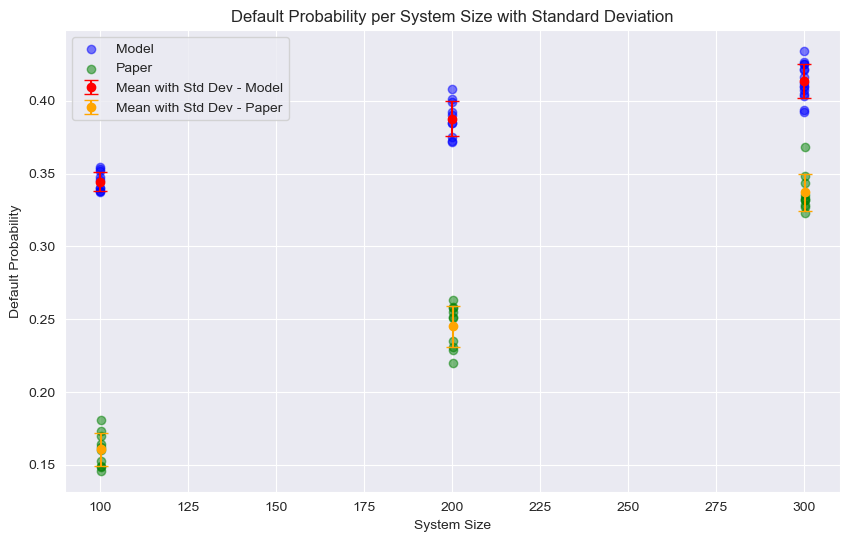

In [48]:
plot_default_size_dot(
    data_array_num_model=data_plot_2_our_model_num_agents,
    data_array_diff_model=data_plot_2_our_model_diff_agents,
    data_array_num_paper=data_plot_2_paper_num_agents,
    data_array_diff_paper=data_plot_2_paper_diff_agents,
    titles=titles,
    system_sizes=system_sizes,
    default_consideration_threshold=default_consideration_threshold
)

In [ ]:
# def plot_default_size(data_array_diff, titles, system_sizes, default_consideration_threshold):
#     all_data = {}  # Dictionary to store default probabilities for each system size

#     # Iterate over each system size and its corresponding data
#     for file_index, (diff_file, title, system_size) in enumerate(zip(data_array_diff, titles, system_sizes)):

#         # List to store default probabilities for this system size
#         default_probabilities = []

#         # Iterate over each run in the dataset
#         for run in range(diff_file.shape[0]):
#             # Extract and convert the difference of bankrupt agents for each run
#             diff_bankrupt_agents = convert_string_to_list(diff_file.iloc[run])

#             if diff_bankrupt_agents:
#                 # Calculate the default probability for this run
#                 default_probability, _ = calculate_default_probability(diff_bankrupt_agents, default_consideration_threshold, system_size)
#                 default_probabilities.append(default_probability)

#         # Store the default probabilities for this system size
#         all_data[system_size] = default_probabilities

#     # Creating box plots
#     plt.figure(figsize=(10, 6))
#     plt.boxplot(all_data.values(), labels=[f'N={size}' for size in all_data.keys()])
#     plt.xlabel('System Size')
#     plt.ylabel('Default Probability')
#     plt.title('Box Plot of Default Probability per System Size')
#     plt.grid(True)
#     plt.show()

In [ ]:
# def plot_default_size(data_array_diff, titles, system_sizes, default_consideration_threshold):
#     all_data = {}  # Dictionary to store default probabilities for each system size

#     # Iterate over each system size and its corresponding data
#     for file_index, (diff_file, title, system_size) in enumerate(zip(data_array_diff, titles, system_sizes)):

#         # List to store default probabilities for this system size
#         default_probabilities = []

#         # Iterate over each run in the dataset
#         for run in range(diff_file.shape[0]):
#             # Extract and convert the difference of bankrupt agents for each run
#             diff_bankrupt_agents = convert_string_to_list(diff_file.iloc[run])

#             if diff_bankrupt_agents:
#                 # Calculate the default probability for this run
#                 default_probability, num_defaults = calculate_default_probability(diff_bankrupt_agents, default_consideration_threshold, system_size)
#                 default_probabilities.append(default_probability)

#         # Store the default probabilities for this system size
#         all_data[system_size] = default_probabilities

#     # Creating box plots
#     plt.figure(figsize=(10, 6))
#     plt.boxplot(all_data.values(), labels=[f'N={size}' for size in all_data.keys()])
#     plt.xlabel('System Size')
#     plt.ylabel('Default Probability')
#     plt.title('Box Plot of Default Probability per System Size')
#     plt.grid(True)
#     plt.show()

# Plot 2: Drupsteen model

# Plot 3

In [ ]:
directory_path = R'.\Data groupmates\Varying sigma\interest'
all_items = os.listdir(directory_path)

In [5]:
def calculate_probability(num_list, threshold = 0.6):
    nums = len([i for i in num_list if i >= threshold])
    return nums / len(num_list)

def group_files(directory: str = './', mode:str = 'sigma_interest_rates'):
    grouped_files = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            parts = filename.split('_')
            if mode == 'sigma_interest_rates':
                key = tuple(parts[:4] + parts[5:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_interest_rates': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_interest_rates'].append(parts[4])
            if mode == 'sigma_exposure_node':
                key = tuple(parts[:3] + parts[4:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_exposure_node': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_exposure_node'].append(parts[3])
    return grouped_files

In [ ]:
def plot_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.figtext(0.5, 0, f"Parameters: {key}", wrap=True, horizontalalignment='center', fontsize=12)
        plt.xlabel(mode.replace('_', ' ').title(), fontsize=14)
        plt.ylabel('Default Prob', fontsize=14)
        plt.title('Avalanche Prob vs. Volatility', fontsize=16)
        plt.show()

In [ ]:
def plot_avalanche_prob_vs_volatility(directory:str = './', threshold=10, mode:str='sigma_interest_rates'):
    groups = group_files(directory, mode)
    all_group_data = []  # This will store the bankruptcy nodes for all groups for ANOVA testing

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else:
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold=threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(np.mean(bankrupt_nodes))  # Use mean probability for ANOVA

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        elif mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.figtext(0.5, 0, f"Parameters: {key}", wrap=True, horizontalalignment='center', fontsize=12)
        plt.xlabel(mode.replace('_', ' ').title(), fontsize=14)
        plt.ylabel('Default Prob', fontsize=14)
        plt.title('Avalanche Prob vs. Volatility', fontsize=16)
        plt.show()

        # Add the list of bankrupt nodes to the all_group_data for ANOVA testing
        all_group_data.append([np.mean(group) for group in bankrupt_nodes_list_sorted])  # Flatten and mean for ANOVA

    # After collecting all the data, perform ANOVA testing
    print(compare_group_means(*all_group_data))

In [ ]:
def plot_avalanche_prob_vs_volatility(directory: str = './', threshold=10, mode: str = 'sigma_interest_rates'):
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold=threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.figtext(0.5, 0, f"Parameters: {key}", wrap=True, horizontalalignment='center', fontsize=12)
        plt.xlabel(mode.replace('_', ' ').title(), fontsize=14)
        plt.ylabel('Default Prob', fontsize=14)
        plt.title('Avalanche Prob vs. Volatility for ' + str(key), fontsize=16)
        
        # Now we perform the ANOVA test
        if len(bankrupt_nodes_list_sorted) >= 2:  # Ensure there are at least 23 groups for ANOVA
            anova_results = compare_group_means(*bankrupt_nodes_list_sorted)
            print(anova_results)
        
        plt.show()

In [ ]:
plot_avalanche_prob_vs_volatility(directory = directory_path, threshold = 20, mode='sigma_interest_rates')

In [6]:
def plot_avalanche_prob_vs_volatility_combined(directory:str = './', threshold = 15, mode:str = 'sigma_exposure_node'):
    groups = group_files(directory, mode)
    plt.figure(figsize=(10, 6))
    colors = ['orange', 'green']
    color_index = 0

    legend_handles = []
    offset = -0.8

    for key, value in groups.items():       
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)
            
        sigmas = value['sigma_exposure_node']
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)

        base_positions = np.arange(len(bankrupt_nodes_list_sorted)) * 2

        positions = base_positions + (color_index * offset - offset / 2)

        color_index += 1
        box_color = colors[color_index % len(colors)]
        boxplots = plt.boxplot(bankrupt_nodes_list_sorted, positions=positions, labels=sigmas_sorted, patch_artist=True,
                               boxprops=dict(facecolor=box_color, color=box_color),
                               medianprops=dict(color=box_color),
                               whiskerprops=dict(color=box_color),
                               capprops=dict(color=box_color),
                               flierprops=dict(markeredgecolor=box_color))

        for patch in boxplots['boxes']:
            patch.set_facecolor(box_color)
        
        legend_handles.append(plt.Line2D([0], [0], color=box_color, label=key[8:]))
    
    plt.figtext(0.5, 0, f"Parameters: {key}", wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.xlabel(mode.replace('_', ' ').title(), fontsize=14)
    plt.ylabel('Default Prob', fontsize=14)
    plt.title('Avalanche Prob vs. Volatility', fontsize=16)
    plt.legend(handles=legend_handles, loc='upper left')
    plt.xticks(base_positions, labels=sigmas_sorted)
    #plt.tight_layout()
    plt.show()

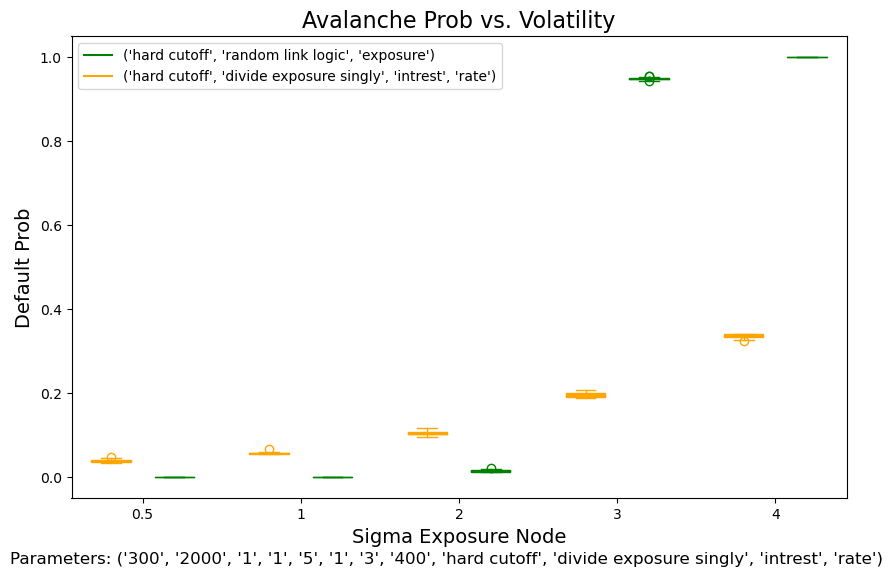

In [7]:
# I changed directory to make sure it can run on my laptop, you may want to change it back to 'directory=directory'
plot_avalanche_prob_vs_volatility_combined(directory = 'exposure', threshold = 15, mode='sigma_exposure_node')

In [ ]:
directory_path = R'.\Data groupmates\Varying sigma\exposure'
all_items = os.listdir(directory_path)

In [ ]:
all_items

In [ ]:
plot_avalanche_prob_vs_volatility(directory = directory_path, threshold = 10, mode='sigma_exposure_node')

In [11]:
# Here I added this line to make sure 3D plot can rotate in jupyter notebook
# but this may cause the image not to be displayed in vscode
%matplotlib notebook

In [9]:
def stress_vs_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_avg_list = []
        total_edge_exposures = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_avg = np.mean(bankrupt_nodes)
            bankrupt_nodes_avg_list.append(bankrupt_nodes_avg)

            exposures = [ast.literal_eval(x) for x in df['Total Absolute Exposure in Edge Weights'] if not pd.isna(x)]
            exposures_avg = [np.mean(x) for x in exposures]
            total_edge_exposure_avg = np.mean(exposures_avg)
            total_edge_exposures.append(total_edge_exposure_avg)

            
        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']

        sigmas = [float(sigma) for sigma in sigmas]
        combined = sorted(zip(sigmas, bankrupt_nodes_avg_list, total_edge_exposures))
        sigmas_sorted, bankrupt_nodes_list_sorted, total_edge_exposures_sorted = zip(*combined)


    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(sigmas_sorted, total_edge_exposures_sorted, bankrupt_nodes_list_sorted)

    ax.set_xlabel(mode.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Total Absolute Exposure in Edge Weights', fontsize=12)
    ax.set_zlabel('Default Prob', fontsize=12)
    ax.set_title('Stress vs. Avalanche Prob vs. Volatility', fontdict={'fontsize': 16})
    #ax.view_init(elev=30, azim=60)

    plt.show()

Key: ('300', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')


<IPython.core.display.Javascript object>


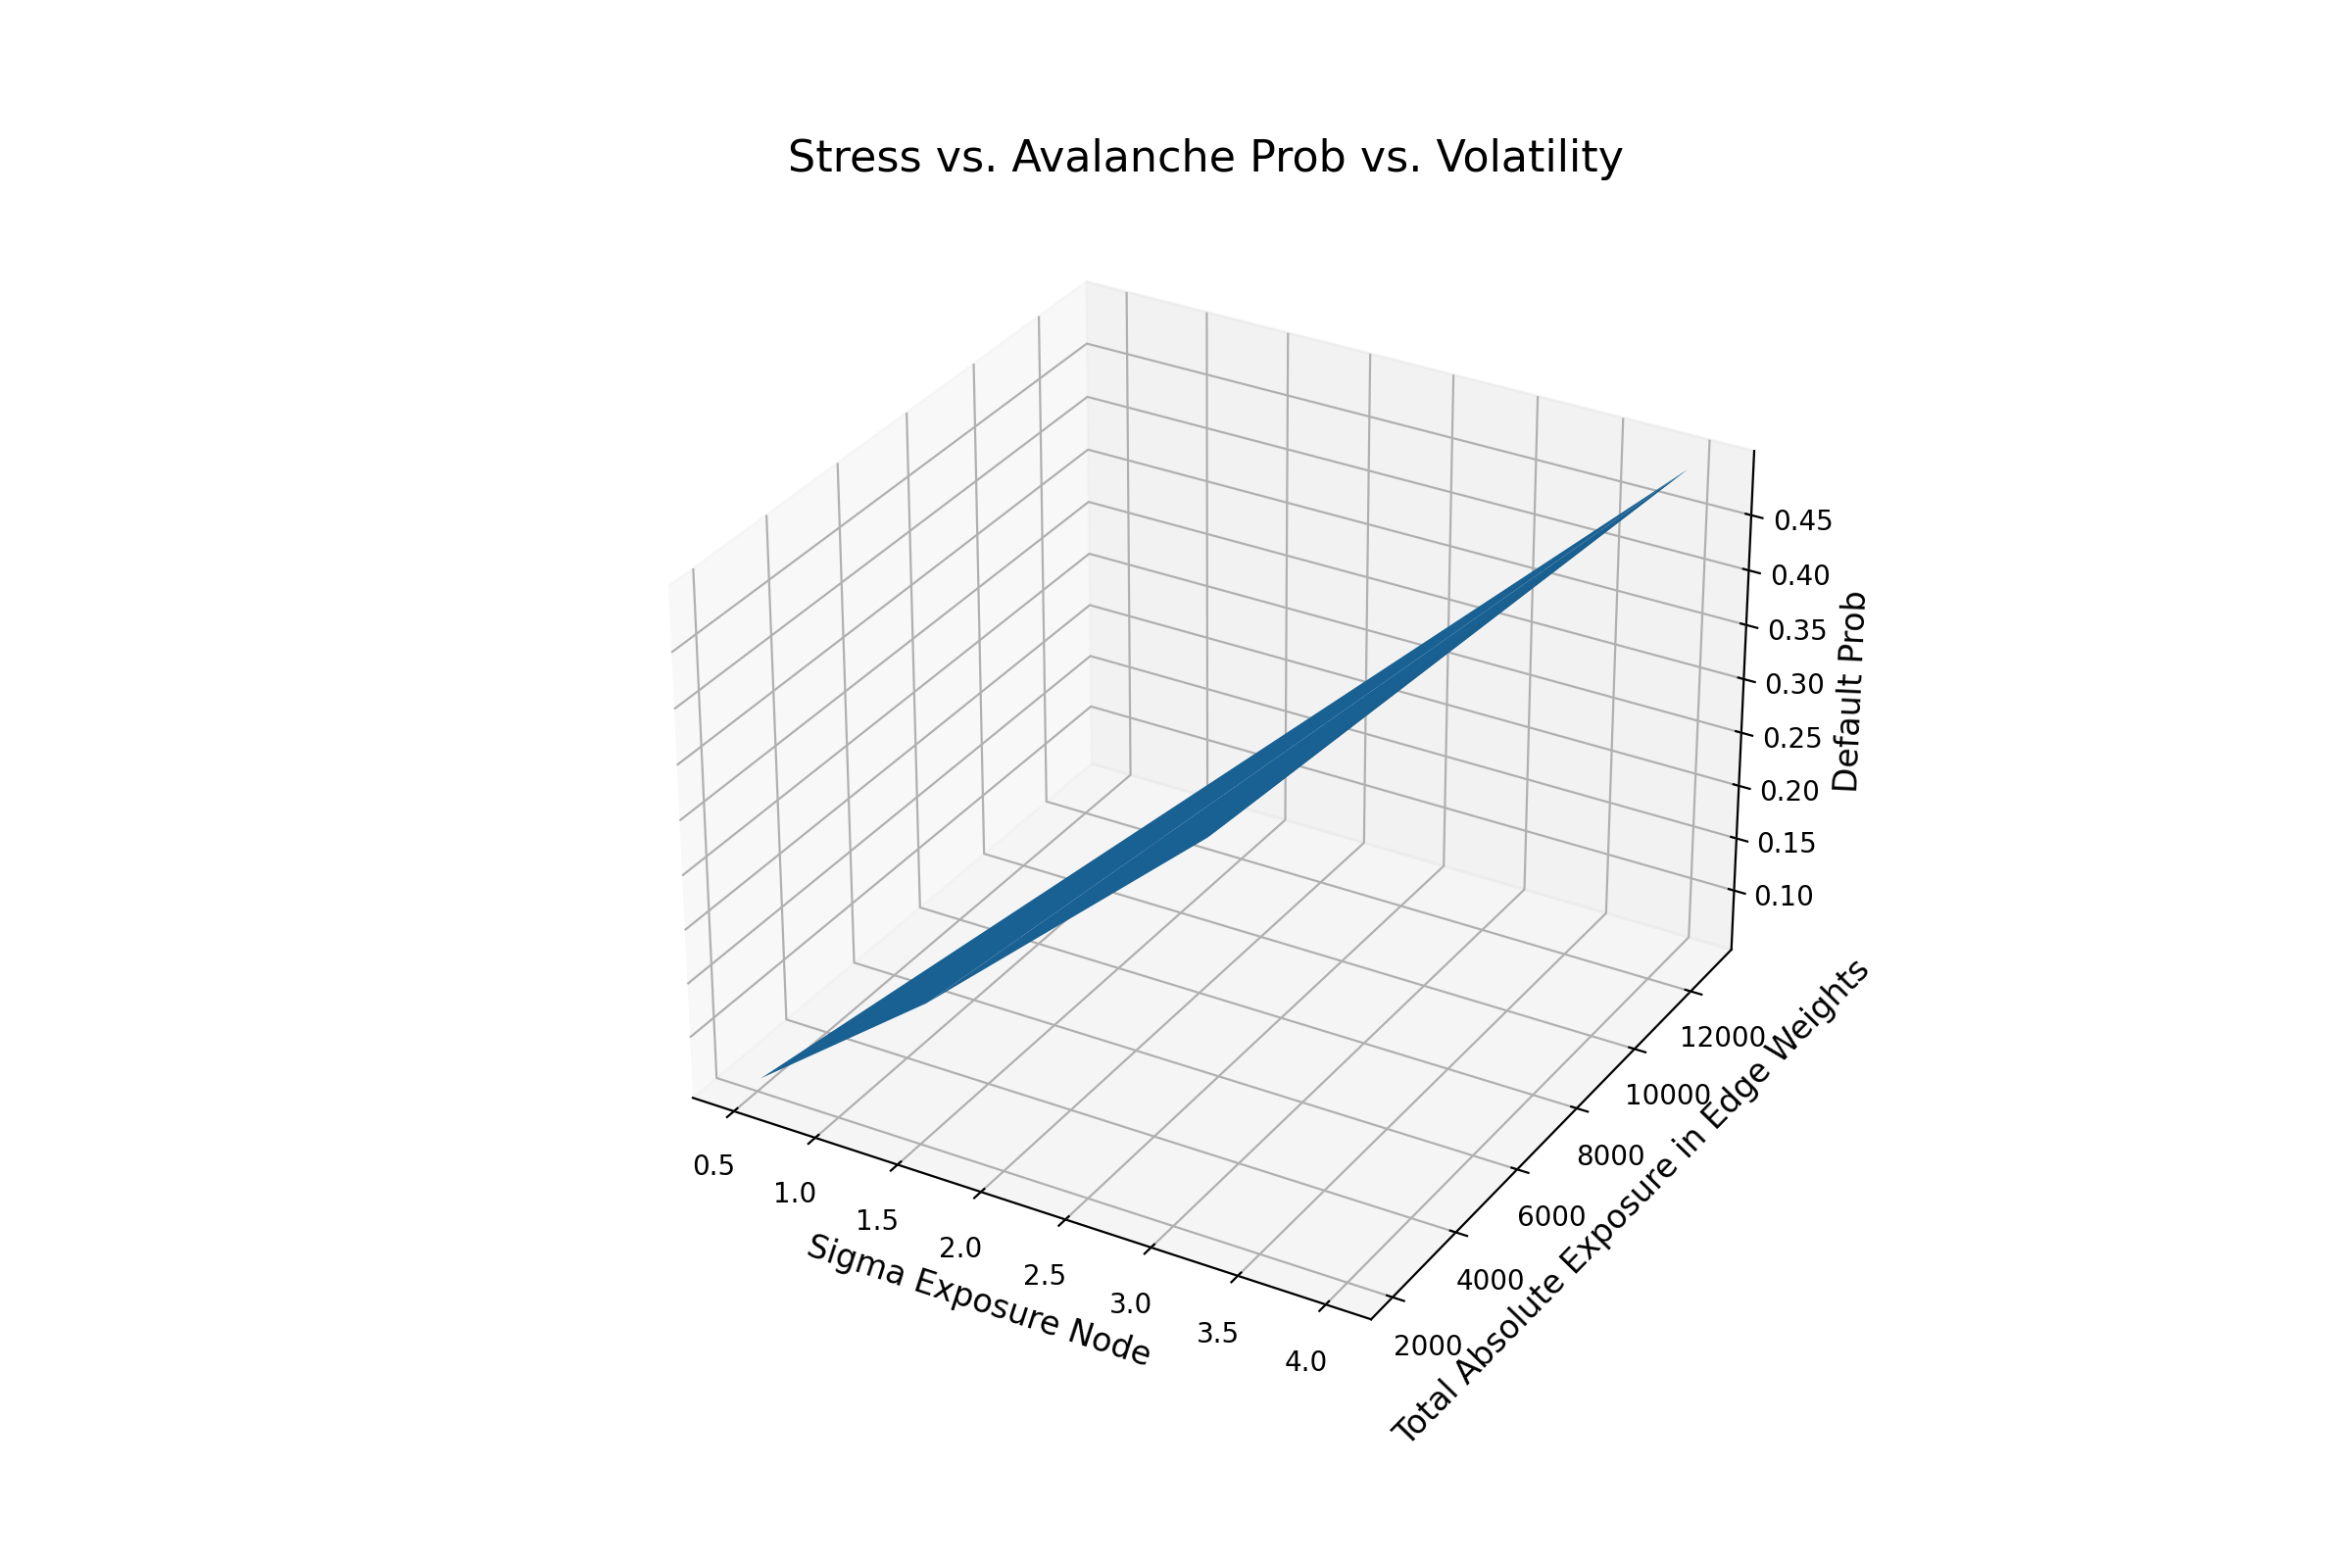

In [12]:
stress_vs_avalanche_prob_vs_volatility(directory=directory_path, mode = 'sigma_exposure_node')

# Plot 4

In [ ]:
directory_path = R'./Data groupmates/Varying threshold/'

# List everything in the directory
all_items = os.listdir(directory_path)


In [ ]:
all_items

In [ ]:
def get_statistics_vary_threshold_v(pattern: str = './200_2000_*.csv'):
    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return np.nan

    def calculate_average_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

    abs_diff_avg_per_run_per_threshold = {}

    for filepath in glob.glob(pattern):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath).replace('.csv', '')
        parts = filename.split('_')
        threshold_v = float(parts[5])
        abs_diff_avg = calculate_average_list(df['Abs Difference of Bankrupt Agents Over Time'])
        if threshold_v not in abs_diff_avg_per_run_per_threshold:
            abs_diff_avg_per_run_per_threshold[threshold_v] = []
        abs_diff_avg_per_run_per_threshold[threshold_v].append(abs_diff_avg)

    return abs_diff_avg_per_run_per_threshold

In [ ]:
def perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds):
    for i in range(min(len(data_to_plot1), len(data_to_plot2))):
        result = compare_group_means(data_to_plot1[i], data_to_plot2[i])
        print(f"Comparison for Threshold {thresholds[i]}: \n {result}\n")

In [ ]:
# First dataset，our model
pattern1 = './Data groupmates/Varying threshold/100_10000_1_1_1_*_1_3_400_hard cutoff_divide exposure singly_intrest_rate_*.csv'
all_results1 = get_statistics_vary_threshold_v(pattern=pattern1)
data1 = all_results1
thresholds1 = list(data1.keys())
data_to_plot1 = []
for values in data1.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot1.append(np.array(flattened_values))
sorted_data1 = sorted(zip(thresholds1, data_to_plot1), key=lambda x: x[0])
thresholds1, data_to_plot1 = zip(*sorted_data1)

# Second dataset, paper model
pattern2 = './Data groupmates/Varying threshold/100_10000_1_1_1_*_1_3_400_hard cutoff_random link logic_exposure_*.csv'
all_results2 = get_statistics_vary_threshold_v(pattern=pattern2)
data2 = all_results2
thresholds2 = list(data2.keys())
data_to_plot2 = []
for values in data2.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot2.append(np.array(flattened_values))
# Sorting the data by threshold values in ascending order
sorted_data2 = sorted(zip(thresholds2, data_to_plot2), key=lambda x: x[0])
thresholds2, data_to_plot2 = zip(*sorted_data2)

# Creating the boxplot
plt.figure(figsize=(10, 6))

# Plotting the boxplot for the first dataset
bp1 = plt.boxplot(data_to_plot1, positions=np.array(range(len(data_to_plot1)))*2.0-0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C0', color='C0'), whiskerprops=dict(color='C0'), capprops=dict(color='C0'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C0'))

# Plotting the boxplot for the second dataset
bp2 = plt.boxplot(data_to_plot2, positions=np.array(range(len(data_to_plot2)))*2.0+0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C1', color='C1'), whiskerprops=dict(color='C1'), capprops=dict(color='C1'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C1'))

# Adding dummy lines for the legend
plt.plot([], c='C0', label='divide exposure singly_intrest_rate')
plt.plot([], c='C1', label='random link logic_exposure')

# Setting the axis labels and title
plt.xlabel('Threshold_v')
plt.ylabel('Abs Difference of Bankrupt Agents Over Time')
plt.title('Boxplot of Abs Difference of Bankrupt Agents Over Time by Threshold_v')

# Setting the tick labels on the x-axis
plt.xticks(np.arange(0, len(thresholds1) * 2, 2), thresholds1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()



plt.show()
# Call the compare_group_means function with your datasets
perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds1)